In [1]:
import re
import requests
import json
import os
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import matplotlib.pyplot as plt

from nltk import tokenize, sent_tokenize, RegexpTokenizer, ngrams
from scipy.sparse import hstack
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, normalize, Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
def generate_wordcloud(text,title,max_words = 50):
    words = text['post_text'].str.cat()
    
    wordcloud = WordCloud(max_words=max_words,background_color='white', max_font_size=50).generate(words)

    # Display the generated image:
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def generate_CDF(data):

    temp_depression = data['num_words_post'].value_counts().sort_index()
    temp_depression /= np.sum(temp_depression.values)
    depression_indice_list = temp_depression.index
    temp_depression = temp_depression.reset_index().drop('index',axis=1)
    CDF_depression = np.zeros(len(temp_depression))
    CDF_depression[0] = temp_depression.iloc[0,0]


    for i in range(1, len(temp_depression)):
        CDF_depression[i] = CDF_depression[i-1] + temp_depression.iloc[i,0]
    return CDF_depression, depression_indice_list

    
    
def vector_transformers(text_column):

    count_vect = CountVectorizer()
    post_text = count_vect.fit_transform(text_column)

    tfidf_transformer = TfidfTransformer()
    post_text_tfidf = tfidf_transformer.fit_transform(post_text)

    return post_text_tfidf


# Clean dataset
def clean_data(dataset):
#     dataset = dataset[dataset['subreddit'] != 'depression']
#     dataset = dataset[dataset['subreddit'] != 'AskReddit']
    dataset['post_text'] = dataset['post_text'].fillna('')
    dataset = dataset[dataset['post_text'] != '[removed]']
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\r', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace('\n', ''))
    dataset['post_text'] = dataset['post_text'].apply(lambda x: x.replace("\'", ""))
    dataset = dataset.dropna()
    dataset = dataset.reset_index()

    return dataset

def post_to_wordlist(post, remove_stopwords=True, split=False):
    
    post = re.sub("[^a-zA-Z]"," ", post)
    words = post.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if split:
        return words
    else:
        return (' '.join(words))

In [3]:
# Load the data and clean it.
# if you have internet connection use the markdown below instead of this code block
# use this one only if you have the data file saved on your machine
df = pd.read_csv(r'/Users/giladgecht/Downloads/temp.csv')

df = shuffle(df)
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

df = pd.read_csv('temp.csv')
encoder = LabelEncoder()
df['_subreddit'] = encoder.fit_transform(df['_subreddit'])
df['_post_text'] = df['_post_text'].fillna('')
df = df[df['_post_text'] != '[removed]']
df = df[df['_title_length'] >= 20]
df = df.dropna()

In [4]:
target = '_subreddit'
cols = '_title'

X = df[cols]
y = df[target]

count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [7]:
print("Accuracy Score:",score)
print(confusion_matrix(y_pred=y_pred,y_true=y_test))
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

Accuracy Score: 0.8677248677248677
[[1613  165]
 [ 210  847]]
AUC Score: 0.9371572658519789


In [8]:
feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs: 
['reddit' 'redditors' 'movie' 'did' 'hype' 'actuslly' 'dirty' 'askreddit'
 'kids' 'thing']

Largest Coefs: 
['depression' 'therapy' 'suicide' 'depressed' 'therapist' 'feels' 'feel'
 'suicidal' 'bed' 'anymore']



In [9]:
# Load main dataset and clean it by removing deleted posts and filling presumed posts with pictures with ''
# Apply the trained LinearSVC classifier on the dataset
whole_data = pd.read_csv(r'/Users/giladgecht/PycharmProjects/DepressionResearch/Create_Data/SubmissionsDF.csv',index_col=0)
whole_data = clean_data(whole_data)
whole_data['predicted'] = svc.predict(count_vect.transform(whole_data['title']))

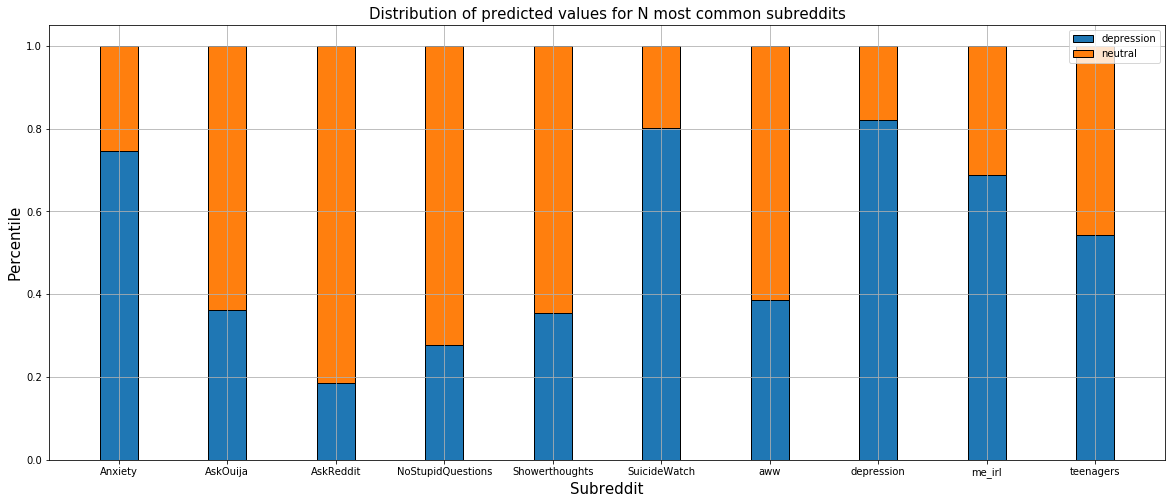

In [10]:
# for the top n common subreddits (probably depression related)
# plot the distribution of predicted neutral posts vs depression posts 
# i.e. subreddit = 'depression', num_posts = 3000, predicted_1 = 2500 (depression), predicted_0 


N = 10
most_common_subreddits = list(whole_data['subreddit'].value_counts().nlargest(N).keys())
most_common_subreddits = whole_data[whole_data['subreddit'].isin(most_common_subreddits)]

temp = most_common_subreddits['subreddit'].value_counts()
sum_subreddit_dict = temp.to_dict()

temp = most_common_subreddits.groupby(['subreddit','predicted'], as_index=False).agg({"submission_id":"count"})
temp['appearance'] = temp['subreddit'].apply(lambda x: sum_subreddit_dict[x])
temp['submission_id'] /= temp['appearance']

pred_depression = temp.iloc[1::2,:]
pred_neutral = temp.iloc[::2,:]

ind = np.arange(N)
width = .35
plt.figure(figsize=(20,8))
p1 = plt.bar(ind, pred_depression['submission_id'], width, edgecolor='k', label='depression')
p2 = plt.bar(ind, pred_neutral['submission_id'], width, edgecolor='k', label='neutral',bottom=pred_depression['submission_id'])


plt.title("Distribution of predicted values for N most common subreddits", size=15)
plt.ylabel('Percentile',size=15)
plt.xlabel('Subreddit', size=15)
plt.xticks(ind, list(pred_depression['subreddit'].values))
plt.legend()
plt.grid()
plt.show()


In [11]:
# Distribution of predicted values
whole_data['predicted'].value_counts()

0    104678
1     80425
Name: predicted, dtype: int64

In [12]:
# Filter out the data by noise
# Subreddits with less than 50 appearences are dropped out 
counts = whole_data['subreddit'].value_counts()
popular_subreddits = counts[counts.values >= 50].keys()
whole_data = whole_data[(whole_data['subreddit'].isin(popular_subreddits))]

In [13]:
# Number of UNIQUE subreddits left after being filtered
subreddits = set(whole_data['subreddit'])
len(subreddits)

585

In [14]:
# Apply a second filter,
# by checking the tendency of a certain subreddit to be either depression or neutral
# if its over 70% towards a certain side, append to the appropriate list

neutral_subreddits = []
depression_subreddits = []
for i in subreddits:
    values = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values
    sum_values = np.sum(whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values)
    values_perc = values/sum_values
    value1 = whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().values[0]
    if whole_data[whole_data['subreddit'] == i]['predicted'].value_counts().keys()[0] == 0:
        if values_perc[0] >= 0.7:
            neutral_subreddits.append(i)
    else:
        if values_perc[0] >= 0.7:
            depression_subreddits.append(i)

In [15]:
# Distribution of depression subreddits 
whole_data[whole_data['subreddit'].isin(depression_subreddits)]['subreddit'].value_counts()

depression             21175
SuicideWatch            1957
Anxiety                 1435
offmychest              1015
mentalhealth             632
selfharm                 609
relationship_advice      555
socialanxiety            534
relationships            421
lonely                   388
BPD                      285
BreakUps                 284
Needafriend              224
MakeNewFriendsHere       193
selfimprovement          175
TrueOffMyChest           171
r4r                      168
DoesAnybodyElse          167
Vent                     157
depression_help          146
dogs                     114
ExNoContact              109
AmItheAsshole             90
ForeverAloneDating        90
Assistance                87
CPTSD                     78
antidepressants           71
depressed                 62
sleep                     56
TalkTherapy               54
cfs                       50
Name: subreddit, dtype: int64

In [16]:
print("The Filtered Neutral Subreddits Are:\n",neutral_subreddits)
print(20*"-")
print("The Filtered Depression Subreddits are:\n", depression_subreddits)

The Filtered Neutral Subreddits Are:
 ['pokemontrades', 'SSBPM', 'mycology', 'Turkey', 'notinteresting', 'suggestmeabook', 'fakehistoryporn', 'friendsafari', 'NoStupidQuestions', 'anime', 'cursedimages', 'CrazyIdeas', 'boottoobig', 'splatoon', 'footballmanagergames', 'Xcom', 'Brawlhalla', 'Animesuggest', 'Cooking', 'DarkSouls2', 'PUBGMobile', 'marvelstudios', 'Entrepreneur', 'Libertarian', 'pyrocynical', 'Philippines', 'politics', 'PhotoshopRequest', 'hardwareswap', 'askscience', 'thesims', 'CrappyDesign', 'Guitar', 'hmmm', 'DeepIntoYouTube', 'borrow', 'baseball', 'OldSchoolCool', 'Tekken', 'StarVStheForcesofEvil', 'mildlyinteresting', 'whatisthisthing', 'edmproduction', 'androidapps', 'AmericanHorrorStory', 'eu4', 'Bossfight', 'magicTCG', 'AskHistorians', 'FifaCareers', 'softwaregore', 'explainlikeimfive', 'Eminem', 'deathgrips', 'translator', 'freefolk', 'travisscott', 'starterpacks', 'WritingPrompts', 'thatHappened', 'Doom', 'IWantToLearn', 'DMT', 'nier', 'Art', 'rarepuppers', 'whow

In [17]:
# Filtered by hand depression-related subreddits
depression_subreddit_filtered_list = ['depression_help', 'lonely', 'SuicideWatch', 'depression',
                                      'selfharm', 'mentalhealth', 'offmychest', 'Anxiety',]

In [18]:
# Split the dataframe to neutral and depressed by the filtered subreddits
depression_df = whole_data[whole_data['subreddit'].isin(depression_subreddit_filtered_list)]
neutral_df = whole_data[whole_data['subreddit'].isin(neutral_subreddits)]

In [19]:
# Get the list of all unique users for each type of dataset
depression_names = list(set(depression_df['user_name']))
neutral_names = list(set(neutral_df['user_name']))

In [20]:
# Merge them back to a single dataframe
full_df = pd.concat([depression_df,neutral_df],axis=0)
full_df.shape

(55909, 16)

In [21]:
# Filter out people who havn't posted in both types of subreddits (Depression/Neutral) in the current dataset
both = []
for i in depression_names:
    if i in neutral_names:
        both.append(i)

In [22]:
full_df = full_df[full_df['user_name'].isin(both)]
full_df = full_df.sort_values(by=['user_name','date_created'],ascending=False)
full_df['num_distinct_words'] = full_df['post_text'].apply(lambda x: len(set(x.split())))

In [23]:
# Create a colum comprised of tri-grams of the post's text
full_df['tokenized'] = full_df['post_text'].apply(lambda x: x.split())

blabla = []
for row in full_df['tokenized']: # Iterate over each row
    generated_3grams = []

    for word in row: # iterate over each word in the row
        generated_3grams.append(list(ngrams(word, 3, pad_left=True, pad_right=False, left_pad_symbol='_')))

    temp_bla = []
    for i in generated_3grams:# iterate over each list in the 3gram
        for j in i: # iterate over each tuple in the current list
            temp_bla.append(j)
    blabla.append(temp_bla)
    
full_df['trigrams'] = 0 
full_df = full_df.reset_index().drop('index',axis=1)

for i in range(len(full_df['trigrams'])):
    full_df['trigrams'][i] = blabla[i]
    
for i in range(len(full_df['trigrams'])):
    ng_list_3grams = full_df['trigrams'][i]
    for idx,val in enumerate(full_df['trigrams'][i]):
        ng_list_3grams[idx] = ''.join(val)
        
        
    full_df['trigrams'][i] = ng_list_3grams

full_df['trigrams'] = full_df['trigrams'].apply(lambda x: ' '.join(x))
full_df = full_df.drop('tokenized',axis=1)

In [24]:
liwc = pd.read_csv('temp2.csv',index_col = 0)
liwc = liwc.dropna()
liwc_submission_ids = list(set(liwc['submission_id']))
liwc.shape

(22447, 86)

In [25]:
X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
X_API_KEY = '584055def86167059a1c1d34'

header = {}
header['X-API-KEY'] = X_API_KEY
header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
header['Content-type'] = 'application/json'

url = 'https://api-v3.receptiviti.com/v3/api/content'

body = """ 
i feel like i’ve waisted it trying to get his help. i can’t connect with him, which makes me feel less like i can open up to him. i don’t particularly enjoy my time there, and i often don’t feel like i’ve gained anything from our sessions.i haven’t gone to see him in a few months. since then i’ve had about 10 mental breakdowns where i’ve felt as though i was hopeless, 5 panic attacks while driving, and like a heck ton of panic attacks at home. whenever i drive i just start crying uncontrollably. whenever i’m at home i hate myself and all i can think about is how i’d rather be dead than living with myself. i keep having panic attacks at work, my work performance is pretty crap because i can’t focus, and i fall asleep while sitting up because i can’t find peace at night.my grades have drastically dropped, and my dad tells me that it’s all my fault, and that i only want a new counselor because my friend has a counselor so i think it’s cool. i hate myself so much right now, and nobody i know has been able to comfort me.i feel so deprived of support, and i just want this feeling to end. if someone told me that they were here for me and gave me a hug i think i would implode on myself, because nobody has held me while i cried or told me that they would be here for me while i struggle with anxiety and depression
"""
#payload = {"content_source": 0,
#                               "language_content": unicode(TextFileContents, errors='ignore')

payload = {"content_source": 0,
                              "language_content": body
          }


#print payload

r = requests.post(url, headers=header, json=payload, timeout=45)
#print r.text
json_to_dump = json.loads(r.text)
# except e as err:
#         print("error"+err.msg)
liwc_cols = list(json_to_dump['liwc_scores']['categories'].keys())

In [26]:
full_df = full_df[full_df['submission_id'].isin(liwc_submission_ids)]

In [27]:
full_df = pd.merge(full_df, liwc,how='left', on='submission_id',)

In [28]:
# Find by using regular expressions all the sentences
# which are built in the following way: "i ...... depress/ed/ion/ants and so on"

count = 0
sentences = []
post = []
subreddits = []
for row in full_df.iterrows():
    
    sentence = row[1]['post_text']
    bla = re.findall(r'\bi\s.*\bdepress[\w]*\b', sentence)
    if len(bla) > 0:
        print(bla)
#         print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        post.append(row[1]['submission_id'])
        subreddits.append(row[1]['subreddit'])
        sentences.append(sentence)
        count += 1
print(count)

['i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucked up or killing myself.that went on for a few weeks and then i decided

['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
Subreddit: depression
----------
['i was legit overwhelmed by support from people here and on a couple of the other depression']
S

['i was diagnosed with clinical depression a couple years ago, and it was a huge turning point in my life. it was arguably the worst time in my life so far. i dropped out of college, couldn’t maintain any creative outlets (i’m a writer), friendships blew up, i had to move back home. after that i was starting to get a handle on my symptoms without medication and had a good amount of self awareness as to when i’m going into a low swing. then i met my boyfriend of almost 8 months before christmas. it’s my first real adult relationship. he’s incredible and we love each other. in the beginning, my symptoms changed to the point that i didn’t recognize them. in those first few months i kept trying to prepare him for the big drop that didn’t come. now that we’re past the honeymoon phase, my symptoms as i know them are starting to come back. to be honest, i don’t think either of us are dealing with it properly. he has his own stuff going on, too. he struggles with depression']
Subreddit: depres

['i lost my scholarship, i was off my meds for about 2 weeks prior... all this shit happened. and on top of that, i went through a fucking rough breakup. impossibly rough. so i looked up a lethal dose of prozac for someone my weight, had lay them out with a bottle of whisky and sent it to my ex and a few other friends.my current ex, s, and i started fighting not long ago about petty shit. i thought she was cheating with two coworkers, l and t. i thought she was lying to me, i was insecure and unstable from my mental illnesses. it got bad. eventually she was at a party with l and t and a few other coworkers and got really drunk with them. a sent me a picture of t and s holding hands, leaning on each other, looked really bad. and he fed me this story about how they were fucking and s was cheating on me. it fucking broke me. l had tried to break us up before, and i know he was having his own issues. i read the texts he sent to s, he was obsessed with s. in a creepy way, s has always said 

Subreddit: depression
----------
['i was young caused some very mild hearing loss and remained the same for awhile. however, now in my twenties suddenly my hearing has gotten significantly worse and i cannot hear above 8khz. i have a loss of about 30db across all frequencies when i got it tested 2 months ago.as a (former) musician, i can no longer hear richness in music and have given up guitar because of it. this has lead to depression']
Subreddit: starterpacks
----------
['i cant get away from myself. ive tried therapy, meds, sensory deprivation, etc. and nothing has helped in the long run. its hard to stay motivated and for the last few weeks ive been feeling much worse than i generally do, however i know its going to get better than this eventually. im trying to use my depression']
Subreddit: depression
----------
['i didn’t mean to, i apologize. she replies with how she doesn’t want my apology. she tells me she has no respect for me, threatens to leave and sometimes does, and when

----------
['i finally decided to get it taken care of by seeing someone. i feel worse than i felt prior to my sessions because i had to relive the feelings, the emotions, the experiences of what made me depressed']
Subreddit: depression
----------
['i had a pretty bad depressive episode last year around the holidays lasting for about 6 months and i feel like its mostly gone at this point. i successfully stopped self harming and only did it again once and havent in about 5 months now. no more suicidal thoughts or anything. and i feel generally better about the future and life at this point, started caring more about school/college plans, and my grades definitely reflect it. at this point i no longer feel persistently sad or anything, ill start to feel it coming back occasionally but im usually able to distract myself and pull myself out of it.the only thing in my life right now thats difficult is.. im trans and though my therapist has been helpful, i havent talked to a gender therapist

----------
['i grew up in a nice neighborhood with nice people and a comfortable living situation, but i always longed for a change. i just kept telling myself once i turn 18, i’ll go to a college i want to go to, and my life will be different.now, i’m 20 years old, and if i had known my life would be the way it is now, i would’ve been incredibly upset as a child. in high school, my parents told me they wanted me to go to a local college for two years, and after that, i could go to a college of my choice. i chose to go to a college two hours away. i had fun the first month, but long story short, my roommate ended up being satan and bullying me. i ended up spiraling into a deep depression and suffering from a lot of anxiety. the next semester, i went to a local community college. i hated it, but it was cheap, i was able to work while being there, and with the gi benefits from my dad, the college is nearly free and i’m getting money for living at home.i kept telling myself i’d transfer b

['i cant even ask a friend cause none of the few friends (which im not even close to) i have smoke. there is one but he wants to hang out but i havent invited him over.i have work tomorrow and its already shitty enough sitting in that unheated truck for 6 hours on a plywood seat in the single digit temperatures (f) and jogging through the snow, not having any clue when my shift will be over at all, or even knowing how soon i have to leave until they call me 15 minutes beforehand. its gonna be much worse with the depression roaring back, having no energy, and aching all over because i cant smoke to stop the physical pain i feel whenever i wake up.i watched "the 40 year old virgin" and during that i could tell my depression was coming back with a vengeance. i just started thinking about how im halfway there, im turning 20 in the spring. and those movie endings never happen. even if they did, hes perfectly healthy, while i havent brushed my teeth consistently in years, have depression']
S

['i was 8. i’m 27 now. it kind of scares me. they do work immensely though.edit: the title is worded wrong. i meant “those who are currently on anti depressants']
Subreddit: depression
----------
['i get very depressed']
Subreddit: depression
----------
['i get very depressed']
Subreddit: Anxiety
----------
['i used to struggle, heavily, with depression between 13-15, 14 (2011) being my worst year where i attempted suicide and almost died. i was put on anti-depressants during that time, but cut them cold turkey after one month due to severe/nightmare fuel hallucinations and growing anger issues that were elevated with my medication when it essentially "wore off". its a can of worms to explain my issues back then, but both my old therapists and i agree it had a lot to do with my home life. it was toxic and i was damn near blamed for every and anything that went wrong in that household. from issues with the rent to any other money problems to my brother being sick (yeah that was somehow 

Subreddit: depression
----------
['i still believe its a good trait to have. but ever since high school ive been especially hard on myself, because during my freshman year i went full on slacker and my grades went to shit; more zeros than anything. after that my family moved and i worked hard to rebuild myself, doubling down on the mentality that im an idiot/asshole, and it worked. i even got into my first relationship with someone who was objectively a shitty person who hurt me horribly at the end, yet i still miss her. sorry for my writing being all over the place, im kind of having a mental break and typing helpstheres a little backstory. my mom dated an asshole we lived with for eight years who verbally abused us both and would hit her. one day when i was at a day camp over the summer i kind of snapped. i dont know how to describe it other than a psychotic break or something. i randomly became horribly paranoid of everything. i remember sitting in the hall of the school that camp w

['i was a daddys girl but when my parents were divorced my fathers alcoholism meant he rarely made our visits, he eventually he died when i was 14 years old. my mothers abuse started after the divorce, at its worst she nearly killed me, we never had a mother/daughter relationship which is something she blames me for, so in adulthood i barely see her (when i do she shows little interest in me). im not at all close with my extended family either, my fathers family completely cut contact after the divorce and im the black sheep of the family on my mothers side, im just not like them and they treat me as a stranger.at school i was the bottom of the social ladder and i was bullied horrifically, in my teens i lost one friend to a car crash and afterwards my other friends were kind of adopted by more popular students...i wasnt, the other students still didnt like me, so my friends would often abandon me to spend time with the popular students. in adulthood ive gone through phases of having no

In [29]:
count = 0
for row in full_df.iterrows():

    sentence = row[1]['post_text']
    bla = re.findall("my[\w]*\s.*depress[\w]*",sentence)
    if len(bla) > 0:
        print(bla)
        print("User:",row[1]['user_name'])
        print("Subreddit:",row[1]['subreddit'])
        print(10*'-')
        count += 1
print(count)

['my name is zavier and im a man that has really fucked up his life. so i took a gap year, and because i really had no idea what to do after that, i decided to go to college. big mistake!things went well at first. i was going to my classes, doing my work, going to the gym everyday. it was everything college should be. then one faithful day, i decided to start doing adderall. hmmm, ive never done any stimulants, this should be an interesting experience!well it sure was because i got addicted almost right away. 1 pill of 30mg xr adderall turned into 4 a day. straight up snorting it most of the time. then id go into crazy mental rampages, buying stupid shit, trying to fuck girls on tinder, etc.and this is where it gets even better. when i finally did fuck a girl i met on tinder, i went absolutely insane! after she cut things off with me, i stopped getting out of bed. i stopped going to class and going to the gym, i just laid in bed and wanted to die all day. id just dream of getting fucke

User: theguyfromuncle420
Subreddit: depression
----------
['my post on r/breakups because this sub is great too:so i’m going through an extremely rough time right now and made a post looking for support with everything and i was legit overwhelmed by support from people here and on a couple of the other depression']
User: theguyfromuncle420
Subreddit: depression
----------
['my post on r/breakups because this sub is great too:so i’m going through an extremely rough time right now and made a post looking for support with everything and i was legit overwhelmed by support from people here and on a couple of the other depression']
User: theguyfromuncle420
Subreddit: depression
----------
['my post on r/breakups because this sub is great too:so i’m going through an extremely rough time right now and made a post looking for support with everything and i was legit overwhelmed by support from people here and on a couple of the other depression']
User: theguyfromuncle420
Subreddit: depression
--

----------
['my 1500$ bill that i literally can not afford. i’m so depressed']
User: sagegambino
Subreddit: depression
----------
['my mom was called in and with her asian cultural background she basically shamed me for being privileged in front of three social workers. she obviously thought the whole ordeal was a waste of time, thinking praying to buddha and being in the sun will completely cure my depressive']
User: sadgirley
Subreddit: depression
----------
['my whole mindset is a lot more negative when i feel really bad, but i always have the impression that people realize when you’re in a weak position and therefore find you less appealing. to me it really sucks, because it further strengthens my depression']
User: sadboi017
Subreddit: depression
----------
['my life to be fulfilling. therefore my life doesn’t get more fulfilling and i get more depressed']
User: sadboi017
Subreddit: depression
----------
['my hormones#acnes & constipationnot sure if it’s because of sleeping disord

Subreddit: depression
----------
['my depression. i still think that it helped with my anxiety though. i would like to think that it did. anyways, the therapist talked about how i was feeling and we didnt really talk much about what is going through my mind. we just talked about why or how i do what i do. so the first session with her didnt go the way i thought it would go. i dont think that it would ever actually help me but i will still go to try to help me.she was for depression']
User: nevillpapermen
Subreddit: Anxiety
----------
['my friend and co-worker told me something from across the room and i couldnt hear him, i asked him to say it again and the person i met today yelled at me "nevermind!" (she wasnt even in the conversation anyway)* my friend is going through some very very hard things right now and i am personally very scared for her safety. she was trying to cut for the first time last night when i was asleep. i feel so bad for not being awake at the time to even try to h

User: kR4in
Subreddit: depression
----------
['my sessions because i had to relive the feelings, the emotions, the experiences of what made me depressed']
User: jxsephmags
Subreddit: depression
----------
['my grades definitely reflect it. at this point i no longer feel persistently sad or anything, ill start to feel it coming back occasionally but im usually able to distract myself and pull myself out of it.the only thing in my life right now thats difficult is.. im trans and though my therapist has been helpful, i havent talked to a gender therapist yet. some days can be pretty rough but i just remind myself that someday everything will be better..what i wonder is, i have this fatigue or tiredness that comes on around 2 - 4 pm almost everyday, and it lasts until i go to sleep, its like an almost overwhelming physically tired and sort of bored feeling where i dont really have the drive to do anything. its almost like the uninterested-in-everything feeling i used to have, where i dont 

['myself for every bad thought that comes into my head. cant sleep at night because if bad or strange dreams all depicting my ex gf about how im such a failure and a loser and i was a mistake and she wished she didnt know me. ive fantasized about how i would kill myself and what everyones lives be like if/when im gone. i just want all this pain and sorrow to leave but i swear misery loves my company. i am a useless pile of shit thats not even worth being a paper weight. i dont even know if its okay for me to be posting on this sub or r/depression']
User: ghost1216
Subreddit: SuicideWatch
----------
['myself and my family. ive struggled with depression']
User: ghost1216
Subreddit: SuicideWatch
----------
['myself and i know even though it’s alright now i’m definitely slipping. even through my life sucked and especially from age 12 to now, i was able to do things very well. the abuse at home was awful but i went to a boarding school and basically preoccupied myself there to distract myse

User: daftmunk
Subreddit: depression
----------
['my depression']
User: daftmunk
Subreddit: depression
----------
['my life not long ago when my ex girlfriend moved far away from me and my best friend (an online friend) blocked me without warning.  the combination of losses was so devastating that it was surreal.  i feel like ever since that period of time, ive lived in a separate shadow reality while everyone else lives in the light reality.  my loneliness is excruciating beyond words.  i try to reach out to people, but my words get lost in translation as they pass from the shadow realm to the light realm.  people hear what they feel like hearing.  i feel like a witch has cursed me with an inability to communicate with others.  i think im communicating clearly, but they hear different meanings than i hear in my own words.  i feel incredibly and incurably isolated.  i can no longer feel love as a giver or recipient.  i feel like im losing my sanity.  i have a therapist, but she lives i

Subreddit: depression
----------
['my act together before it was to late?" its hard to explain.. i hurted my mother and stepdad with my selfishness and stupidity, and now both of them are dead.  theres no way i can make amends now.  once you die,  its over.  youre fucked..  i remember as a child,  i had this feeling my mom was going to die pretty soon,  but i will always push that voice in the back of my head.  and now look... the only people i can make amends with are my stepslibings.  and i lost contact with them 14 years ago. reconciling with them is basically pointless,  to much time has passed.  including,  im pretty sure they have families of their own.  its to late.. im sorry for rambling guys,  but this burdening me down since i was 7 years olds.  sometimes i feel like im in a bad dream,  and once i wake up none of this shit is real.  the guilt, regret, and self loathing is the biggest factor to my depression']
User: black-trash-man
Subreddit: depression
----------
['my co-work

['my favorite time of year, is over again. i think i was in denial for a while, but its true, and i have to go back to college. i am dreading it more than ever. every year i go through this. this year was a particularly rough one. there was a mixture of personal/family issues and the result was i became reclusive only going out a few times the whole summer.i finished the semester in may thinking i had a great summer ahead. then i sunk into this depressive']
User: VarokSaurfang
Subreddit: depression
----------
['my bed with music playing, and felt the tears build up in the corner of my eyes, feeling that breakdown hover in my throat. it always feels pathetic to cry and feel like this as a 23 year old dude.. youd think after 6-8 years id be used to it.im terrified of the way i feel.. ive lost interest in the one thing i had passion for recently and that is gaming, mostly for the escapism.. id normally take any method of escapism i can get, but i couldnt even do that this week.i do want t

In [30]:
# Find out how many unique users we found who match our regular expressions - by submission id
# this is done to get only their depression related posts and not their entire posts
# Later on, we'll take the rest of their post and categorize them as neutral based
# this will be our compare group
users_filtered_by_re = list(set(post))
len(list(set(post)))

1852

In [31]:
# Get all the unique users found in the previous step
filtered_by_re = full_df[full_df['submission_id'].isin(users_filtered_by_re)].copy()

In [32]:
# Take n largest subreddit by appreance in the filtered dataset
n_largest = list(filtered_by_re['subreddit'].value_counts().nlargest(8).keys())

In [33]:
# Create the final depressed testing group to be compared with neutral people
# by taking the depressed test group user id's, we can create the group's neutral posts
depressed_group_depressed_posts = filtered_by_re[filtered_by_re['subreddit'].isin(n_largest)]
depression_group_users = list(set(depressed_group_depressed_posts['user_name']))
depression_group_users_indices = list(set(depressed_group_depressed_posts['user_name'].index))

In [34]:
# Create a list of all the possible neutral predicted posts which contain our regular expression
temp_list = list(depressed_group_depressed_posts[depressed_group_depressed_posts['predicted'] == 0]['submission_id'].index)

In [35]:
# First, create the dataset comprised of the same users we have in our depression dataset
# Second, take only the neutral related posts of these users
# Third, drop out the posts which were filtered by the regular expression and are now considered depression wise
# Fourth, Filter out empty posts and keep only the ones above 50 words, this leaves us with an almost similar in size dataset
depression_group_users_neutral_posts = full_df[full_df['user_name'].isin(depression_group_users)]
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['predicted'] == 0]
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop(temp_list,axis=0)
depression_group_users_neutral_posts = depression_group_users_neutral_posts[depression_group_users_neutral_posts['num_words_post'] > 50]

In [36]:
# Create a dataset comprised of all the other users who weren't classified as depressed by our regular expression
# next, we only want those who we classified by our original classifier, who were predicted as neutral => predicted = 0
non_depressed_people = full_df.drop(depression_group_users_indices,axis=0).copy()
non_depressed_people = non_depressed_people[non_depressed_people['predicted'] == 0]
non_depressed_people = non_depressed_people[non_depressed_people['num_words_post'] > 50]
non_depressed_people.shape

(2261, 103)

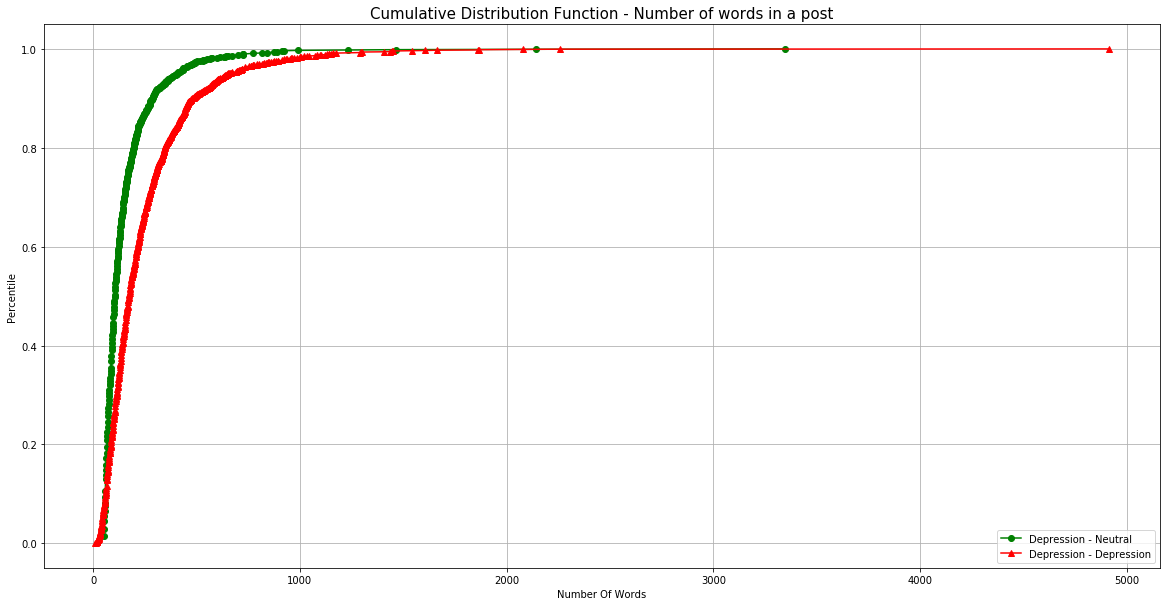

In [37]:
CDF_neutral, neutral_indice_list = generate_CDF(data=depression_group_users_neutral_posts)
CDF_depression, depression_indice_list = generate_CDF(data=depressed_group_depressed_posts)
#CDF_neutral_neutral, neutral_neutral_list = generate_CDF(data= non_depressed_people)

plt.figure(figsize=(20,10))
plt.plot(neutral_indice_list.values, CDF_neutral,color='green',marker='o', label='Depression - Neutral')
plt.plot(depression_indice_list.values, CDF_depression,color='red',marker='^', label='Depression - Depression')
#plt.plot(neutral_neutral_list.values, CDF_neutral_neutral,color='blue',marker='*', label='Neutral - Neutral')

plt.legend()
plt.title("Cumulative Distribution Function - Number of words in a post", size=15)
plt.ylabel("Percentile",size=10)
plt.xlabel("Number Of Words",size=10)
plt.grid()
plt.show()

In [38]:
# Lets drop the predicted column from our test groups
non_depressed_people = non_depressed_people.drop('predicted', axis=1)
depressed_group_depressed_posts = depressed_group_depressed_posts.drop('predicted', axis=1)

non_depressed_people['is_depressed'] = 0
depressed_group_depressed_posts['is_depressed'] = 1

In [39]:
# Combine both datasets
depressed_vs_neutral = pd.concat((non_depressed_people, depressed_group_depressed_posts), axis=0)
X = depressed_vs_neutral['post_text']
y = depressed_vs_neutral['is_depressed']

In [40]:
# Data transformation => Countvectorizer and Tfidf transformer
# removing english stopwords and analyzing on the word level
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [41]:
tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [42]:
# Simple 80/20 ratio train/test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Applying a Linear Support Vector Classifier on our data
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 1,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [44]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.9471153846153846
AUC Score: 0.980099222939671

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,444,30
actual depression,14,344


feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [45]:
# Now lets try to classify and destinguish between the depression groups' neutral posts
# from the neutral group's posts
depression_group_users_neutral_posts = depression_group_users_neutral_posts.drop('predicted', axis=1)
depression_group_users_neutral_posts['is_depressed'] = 1

In [46]:
depressed_vs_neutral = pd.concat((non_depressed_people, depression_group_users_neutral_posts), axis=0)
X = depressed_vs_neutral['post_text'].map(post_to_wordlist)
y = depressed_vs_neutral['is_depressed']

In [47]:
count_vect = CountVectorizer(stop_words='english', lowercase=True,analyzer='word')
X = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

In [48]:
tri_grams_X = count_vect.fit_transform(depressed_vs_neutral['trigrams'].values)
tri_grams_X = tfidf_transformer.fit_transform(tri_grams_X)
X = hstack((X, tri_grams_X,depressed_vs_neutral[liwc_cols]))

In [49]:
extra_features = normalize(depressed_vs_neutral[['post_length','num_distinct_words']], axis=1)

In [50]:
X.shape

(3605, 31284)

In [51]:
X = hstack((X, extra_features))

In [52]:
X

<3605x31286 sparse matrix of type '<class 'numpy.float64'>'
	with 1371146 stored elements in COOrdinate format>

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
svc = LinearSVC(random_state=42, penalty='l2', dual= True, tol=0.0001, C = 100,
                fit_intercept= True, intercept_scaling=1.0, class_weight= None)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
score = svc.score(X_test, y_test)

In [55]:
print("Accuracy Score:",score)
print("AUC Score:", np.mean(cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc')))

print("\n\t# === Confusion Matrix === #")
confusion_matrix_df = pd.DataFrame(data=confusion_matrix(y_pred=y_pred,y_true=y_test))
confusion_matrix_df.columns = ['predicted neutral', 'predicted depression']
confusion_matrix_df.index = ['actual neutral', 'actual depression']
confusion_matrix_df

Accuracy Score: 0.23439667128987518
AUC Score: 0.16502906875576992

	# === Confusion Matrix === #


,predicted neutral,predicted depression
actual neutral,142,321
actual depression,231,27


feature_names = np.array(count_vect.get_feature_names())
sorted_coef_index = svc.coef_[0].argsort()

print('Smallest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

In [56]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))
        
no_features = 1000

tfidf_vectorizer = TfidfVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(depressed_group_depressed_posts['post_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(depressed_group_depressed_posts['post_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [57]:
no_topics = 10

nmf = NMF(n_components=no_topics, random_state = 42, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50, random_state=42)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=10, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [58]:
no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
print("-------------------------------")
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
fucking shit fuck hate just people want god die happy
Topic 1:
don ve know want ll just doesn depressed anymore really
Topic 2:
facebook ended blocking gaslighting pains responsibility intent spoken time toxic
Topic 3:
just depression time life day ive like years things anxiety
Topic 4:
replied acting really blame gives group knows hes course youre
Topic 5:
job work jobs quit working money college career getting hate
Topic 6:
dont want know just think hate people im really ill
Topic 7:
support women grateful post talk said woman tend overwhelmed speaking
Topic 8:
im ive depressed going just know dont thats tired scared
Topic 9:
feel like depressed feeling makes just way feels depression happy
-------------------------------
Topic 0:
wanna dont feel just 2018 water meet food people eat
Topic 1:
just know depression don time like anymore feel im kind
Topic 2:
im dont just like depression feel ive know want people
Topic 3:
dark group smoking depressed hes community open place sho

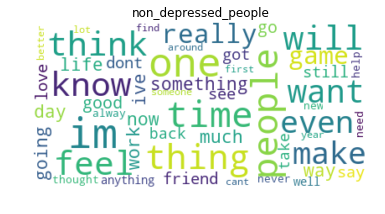

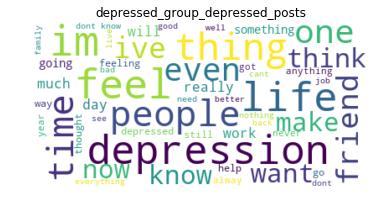

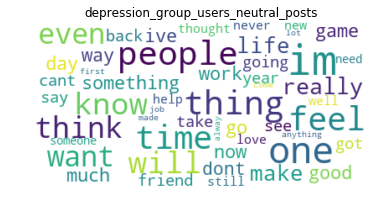

In [59]:
# Generate Word Clouds for each group
texts = [non_depressed_people, depressed_group_depressed_posts, depression_group_users_neutral_posts]
titles = ['non_depressed_people', 'depressed_group_depressed_posts', 'depression_group_users_neutral_posts']
for i,x in zip(texts,titles):
    generate_wordcloud(text=i,title=x)

In [60]:
temp_df = full_df[full_df['post_length'] > 0][['post_text','submission_id']].copy()
for i in liwc_cols:
    temp_df[i] = i
temp_df = temp_df.reset_index().drop('index',axis=1)
temp_df.head()

,post_text,submission_id,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward
0,ugh. im usually up late at night when theres n...,a0sk9r,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward
1,hello. my name is zavier and im a man that has...,9vh52o,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward
2,i hate myself so much. i dropped a class becau...,9lh9og,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward
3,"i have such a short wick nowadays, and am alwa...",aboyzz,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward
4,some of them have no clue what it feels like t...,a2voyg,family,feel,money,insight,number,Parenth,cogproc,OtherP,...,AllPunc,Apostro,i,posemo,ingest,Dash,swear,Comma,time,reward


In [61]:
def liwc_analysis(text):
    X_API_SECRET_KEY = 'tg3OK1kcQdU8RXjx2ghyjNcB6vmg82nYALAS3ImVBYg'
    X_API_KEY = '584055def86167059a1c1d34'

    header = {}
    header['X-API-KEY'] = X_API_KEY
    header['X-API-SECRET-KEY'] = X_API_SECRET_KEY
    header['Content-type'] = 'application/json'

    url = 'https://api-v3.receptiviti.com/v3/api/content'
    
    
    payload = {"content_source": 0,
                              "language_content": text
          }
    try:    
        r = requests.post(url, headers=header, json=payload, timeout=45)
        json_to_dump = json.loads(r.text)
        return json_to_dump['liwc_scores']['categories']

    except Exception as e:
        print("error")
        pass


def create_liwc_df(text,temp):
    for i in range(1,len(text)):
        print(text[i])
        text = liwc_analysis(text[i])
        temp_obj = pd.DataFrame(data=text, index=[i])
        temp = pd.concat((temp, temp_obj), axis=0)
    return temp

liwc_obj = liwc_analysis(temp_df['post_text'][0])

temp = pd.DataFrame(data=liwc_obj, index=[0])
blu = pd.Series(data=temp_df['submission_id'][0],name='submission_id')
temp = pd.concat((temp,blu),axis=1)
for i in range(1, len(temp_df)):
    print(i)
    text = liwc_analysis(temp_df['post_text'][i])
    temp_obj = pd.DataFrame(data=text, index=[0])
    temp_series = pd.Series(data=full_df['submission_id'][i], name='submission_id')
    temp_obj = pd.concat((temp_obj, temp_series), axis=1)
    temp = pd.concat((temp, temp_obj), axis=0)


temp.to_csv('temp2.csv')
